In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import csv
import os
import time

np.random.seed(1234)

In [2]:
# CUDA support
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA")
else:
    device = torch.device("cpu")
    print("CPU")

CUDA


In [3]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

In [13]:
lbfgs_lr = 0.1
adam_lr = 0.01

w_pde = 1
w_bc = 1
w_ic = 1

In [14]:
class PINN():
    def __init__(self, x, t, layers, lb, rb, f):
        
        self.x = torch.tensor(x, requires_grad=True).float().to(device)
        self.t = torch.tensor(t, requires_grad=True).float().to(device)
        self.f = torch.tensor(f).float().to(device)

        self.lb = lb
        self.rb = rb

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=lbfgs_lr,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=adam_lr)
        self.iter = 0

    def model_value(self, x, t):
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def boundary_condition(self, cond, u, u_x, u_2x, u_3x):
        bc_loss = 0

        match cond:
            case 'pinned':
                bc_loss += u**2 + u_2x**2
            case 'fixed':
                bc_loss += u**2 + u_x**2
            case 'free':
                bc_loss += u_2x**2 + u_3x**2
            case 'roller':
                bc_loss += u_x**2 + u_3x**2

        return bc_loss
    
    def initial_condition(self, func):
        ic_loss = 0


        

    def loss_func(self, x, t):
        u = self.model_value(x, t)
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_2x = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
        u_3x = torch.autograd.grad(u_2x, x, torch.ones_like(u_2x), create_graph=True)[0]
        u_4x = torch.autograd.grad(u_3x, x, torch.ones_like(u_3x), create_graph=True)[0]

        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        u_2t = torch.autograd.grad(u_t, t, torch.ones_like(u_t), create_graph=True)[0]

        # BC
        bc_loss = self.boundary_condition(self.lb, u[0], u_x[0], u_2x[0], u_3x[0])
        bc_loss += self.boundary_condition(self.rb, u[-1], u_x[-1], u_2x[-1], u_3x[-1])

        # PDE
        residual = torch.mean((u_2t + u_4x - self.f)**2)

        total_loss = w_pde * residual + w_bc * bc_loss
        return total_loss


    def lbfgs_func(self):
        loss = self.loss_func(self.x)

        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        self.iter += 1
        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
        return loss
    
    def train(self, epochs=1000):
        self.dnn.train()
        for epoch in range(epochs):
            loss = self.loss_func(self.x)

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")

        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, X, q_c, L, E, I):
        x = torch.tensor(X, requires_grad=True).float().to(device)

        self.dnn.eval()
        u_c = self.model_value(x)
        u_c = u_c.detach().cpu().numpy()
        u = (q_c * L**4 / (E*I)) * u_c

        final_loss = self.loss_func(self.x)
        final_loss = final_loss.detach().cpu().numpy()
        return u, final_loss[0]

In [15]:
def func(x, t):
    return (1-16*np.pi**2) * np.sin(x) * np.cos(4*np.pi*t)

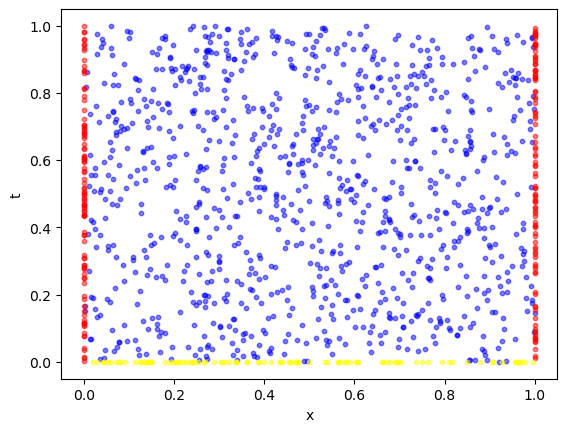

In [5]:
epochs = 600
n_points = 1000

def ic_points(n_points):
    x = torch.rand(n_points, device=device)
    t = torch.zeros(n_points, device=device)
    return torch.stack([x, t], dim=1)

def bc_points(n_points, x_bc):
    x = torch.ones(n_points, device=device) * x_bc
    t = torch.rand(n_points, device=device)
    return torch.stack([x, t], dim=1)

def domain_points(n_points):
    x = torch.rand(n_points, device=device)
    t = torch.rand(n_points, device=device)
    return torch.stack([x, t], dim=1)

d = domain_points(n_points)
bc1 = bc_points(100, 0)
bc2 = bc_points(100, 1)
ic = ic_points(100)

x1 = d[:, 0].cpu().numpy()
t1 = d[:, 1].cpu().numpy()

x2 = bc1[:, 0].cpu().numpy()
t2 = bc1[:, 1].cpu().numpy()

x3 = bc2[:, 0].cpu().numpy()
t3 = bc2[:, 1].cpu().numpy()

x4 = ic[:, 0].cpu().numpy()
t4 = ic[:, 1].cpu().numpy()

plt.scatter(x1, t1, s=10, color="blue", alpha=0.5)
plt.scatter(x2, t2, s=10, color="red", alpha=0.5)
plt.scatter(x3, t3, s=10, color="red", alpha=0.5)
plt.scatter(x4, t4, s=10, color="yellow", alpha=0.5)
plt.xlabel("x")
plt.ylabel("t")
plt.show()


In [15]:
import matplotlib.animation as animation

# Exact solution

def exact_solution(x, t):
    return np.sin(x)*np.cos(4*np.pi*t)


x = np.linspace(0, np.pi, 100)
t = np.linspace(0, 1, 100)

X, T = np.meshgrid(x, t)
U = np.sin(X) * np.cos(4 * np.pi * T) 

print(U)

# # Set up the figure and axis
# fig, ax = plt.subplots()
# ax.set_xlim(0, np.pi)
# ax.set_ylim(-1, 1)
# ax.set_xlabel("x")
# ax.set_ylabel("u(x, t)")
# ax.set_title("Animation of Exact Solution")


# # Initialize the line object
# line, = ax.plot([], [], lw=2)

# # Initialization function: Clears the line data
# def init():
#     line.set_data([], [])
#     return line,

# # Update function for each frame
# def update(frame):
#     y = exact_solution(x, t[frame])  # Compute solution at current time step
#     line.set_data(x, y)
#     return line,

# # Create the animation
# ani = animation.FuncAnimation(fig, update, frames=len(t), init_func=init, blit=True, interval=50)

# ani.save("wave_animation.gif", writer="pillow", fps=30)

[[0.00000000e+00 3.17279335e-02 6.34239197e-02 ... 6.34239197e-02
  3.17279335e-02 1.22464680e-16]
 [0.00000000e+00 3.14726763e-02 6.29136624e-02 ... 6.29136624e-02
  3.14726763e-02 1.21479429e-16]
 [0.00000000e+00 3.07110120e-02 6.13911007e-02 ... 6.13911007e-02
  3.07110120e-02 1.18539528e-16]
 ...
 [0.00000000e+00 3.07110120e-02 6.13911007e-02 ... 6.13911007e-02
  3.07110120e-02 1.18539528e-16]
 [0.00000000e+00 3.14726763e-02 6.29136624e-02 ... 6.29136624e-02
  3.14726763e-02 1.21479429e-16]
 [0.00000000e+00 3.17279335e-02 6.34239197e-02 ... 6.34239197e-02
  3.17279335e-02 1.22464680e-16]]
